## Data Science Central Challenge: Identifying patterns in complex time series 

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import datetime

train=pd.read_csv("DATA/DSC_Time_Series_Challenge.csv",dtype = {'Day ':str,'Pageviews':int})[:]
time=[datetime.datetime.strptime(t[0],"%m/%d/%y") for t in train[['Day ']].values]
weekday=[datetime.datetime.strptime(t[0],"%m/%d/%y").isocalendar()[2] for t in train[['Day ']].values]
month=[datetime.datetime.strptime(t[0],"%m/%d/%y").month for t in train[['Day ']].values]
train['time']=time
train['index']=np.arange(0,len(train))
train['weekday']=weekday

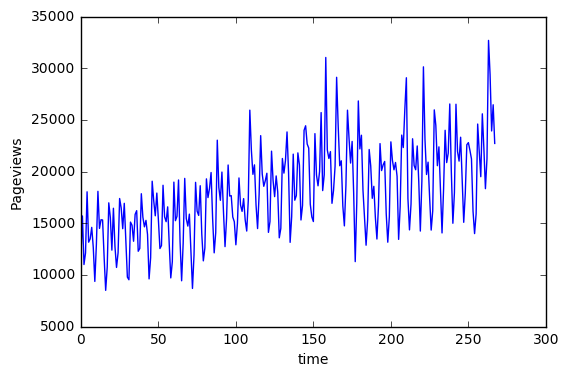

array([0, 1, 2, 3, 4, 5, 6])

In [2]:
time_component='index'

# seasonal_component='weekday'

seasonal_list=['weekday']

for seasonal_component in seasonal_list:
    minsec=min(train[seasonal_component])
    maxsec=max(train[seasonal_component])
    train[seasonal_component]=train[seasonal_component].apply(lambda x: (x - minsec))
    
    

train=train.sort_values(by=[time_component])

plt.plot(train['index'],train['Pageviews'],'-')
plt.xlabel('time')
plt.ylabel('Pageviews')
plt.show()

np.unique(train['weekday'])

## Find seasonal patterns:

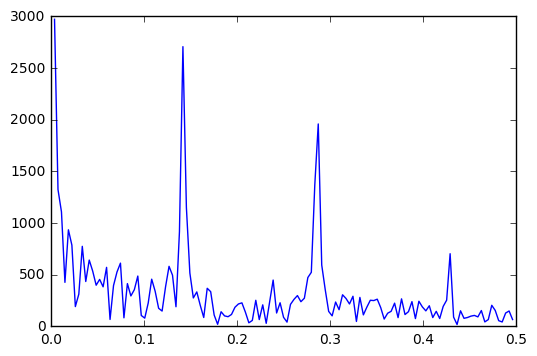

In [3]:
T=3./800 
N=len(train)
tr=[]


yf = np.fft.fft(train['Pageviews'])
freq= np.fft.fftfreq(len(yf))


from scipy.fftpack import fft
from scipy.fftpack import ifft
from scipy.fftpack import fftfreq
import matplotlib.pyplot as plt

yf = fft(train['Pageviews'])
freq= fftfreq(len(yf))
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
y_abs=( 2.0/N * np.abs(yf[:N//2]))

plt.plot(freq[1:N//2],2.0/N * np.abs(yf[1:N//2]))
plt.show()


In [4]:
def filter_trend(x,freq,band,f_signal):

    if abs(freq)>f_signal+band or abs(freq)<f_signal-band or (2.0/N *np.abs(x))<=1500:
        return (0,0)
    else:
        return (np.absolute(freq),x)

    

### Assuming this means finding the "seasonal" frequencies, I found dominant frequencies at 1, 38.1, and 77.19 at a cut off magnitude of 1500. 

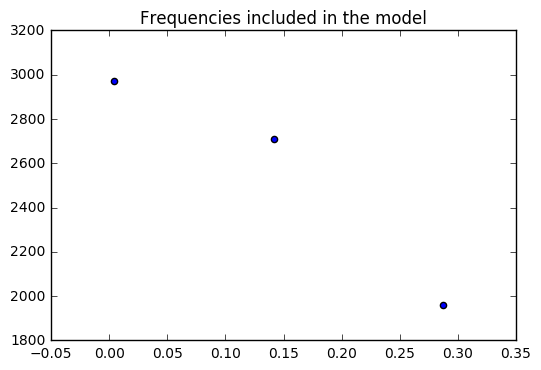

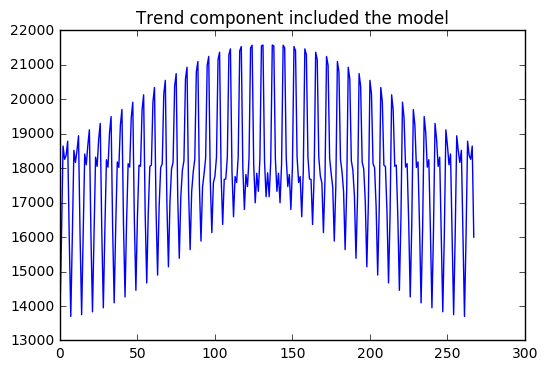

[0.0037313432835820895, 0.1417910447761194, 0.28731343283582089]

In [5]:

F_filtered = np.array([filter_trend(x,f,.2,.2) for x,f in zip(yf,freq)])
n=len(train)
signal=np.zeros(len(train))
t=np.arange(0,len(train))
for f,component in F_filtered:
    signal+= np.absolute(component)/n * np.cos(2*np.pi*np.absolute(f)*t+np.angle(component))
train['trend']=signal


frequency_components=[]
amplitude=[]
for i,x in zip(freq[1:],y_abs[1:]):
    f_signal=.2
    band=.2
    if abs(i)>f_signal+band or abs(i)<f_signal-band or np.abs(x)<1500:
        pass
    else:
        frequency_components.append(i)
        amplitude.append(x)
        
    
plt.scatter(frequency_components,
        amplitude)
plt.title("Frequencies included in the model")
plt.show()

plt.plot(t,signal,'-')
plt.title('Trend component included the model')
plt.show()


frequency_components

In [6]:
input_df2=train[seasonal_list]
output=train[['Pageviews']]
y=output.values
input_=input_df2.values
m,n =np.shape(input_)
x=input_

frequency_components = 2*np.pi*np.outer(frequency_components,np.ones(x.shape[1])).reshape((len(frequency_components),x.shape[1]))
print(frequency_components)


trig_args = np.dot(frequency_components,x.T ).T
print(x.shape[:],frequency_components.shape[:],trig_args.shape[:])
seasonal_x = np.column_stack((np.sin(trig_args),np.cos(trig_args)))

[[ 0.02344472]
 [ 0.89089941]
 [ 1.80524354]]
(268, 1) (3, 1) (268, 3)


1044824833.76
[  5.17770948e+09]


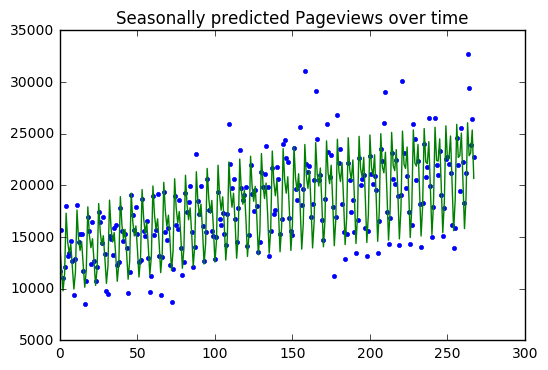

In [8]:
m,n =np.shape(seasonal_x)
# print(seasonal_x)
x=np.ones((m,n+3))
x[:,1:]=np.column_stack((seasonal_x,train['trend'],train['index']))


A=x.T.dot(x)
b=x.T.dot(y)
z = np.linalg.solve(A,b)

SSE=np.sum((y-x.dot(z))**2)
print(SSE)
print(sum((y-np.mean(y))**2))

plt.plot(train['index'],y,'.')
plt.plot(train['index'],x.dot(z),'-')
plt.title("Seasonally predicted Pageviews over time")
plt.show()


## Which weekday are the peaks located at? 

In [9]:
peaks=[]
for i,xz in enumerate(x.dot(z)):
    if i>0 and i<len(x.dot(z))-1:
        if x.dot(z)[i]>x.dot(z)[i-1] and x.dot(z)[i]>x.dot(z)[i+1]:
            peaks.append(train['time'][i].isocalendar()[2])
print("peaks: ",np.unique(peaks))


peaks:  [1 4]


## Are the peaks getting smaller over time?

### After accounting for seasonality and trend, the peaks seem to be getting larger.

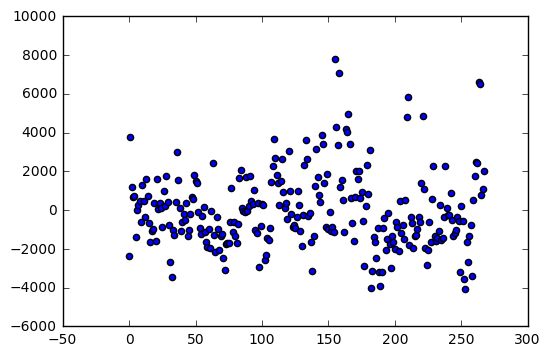

In [10]:
plt.scatter(train['index'],y-x.dot(z))
plt.show()

## The residual plot is not indicative of heteroscedasticity because while there is a funnel shape, there are only a few outliers.